In [1]:
import json
from sklearn.model_selection import train_test_split
from cleantext import clean
import matplotlib.pyplot as plt

# Import all of the training data from the json file
data = []
with open('musicReviews.json') as f:
    for line in f:
        data.append(json.loads(line))

# Extract only the overall rating and the text
def extractor(json):
    return json["overall"], json["reviewText"]

# Store the text and ratings in lists
features = []
targets = []
for d in data:
    score, text = extractor(d)
    features.append(clean(text))
    targets.append(int(score))

# Split the set into training and testing to evaluate testing later
X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.1, random_state=42)

# Bin to see the distribution of the classes for sampling in case of inbalance
bins_training = plt.hist(y_train,bins=5)

## Test set

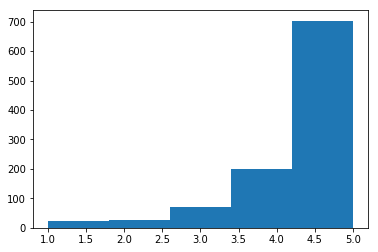

In [2]:
# As the training set is in balanced, the same will occur in the test set
# Therefore, we will use a balanced metric and need weighting factors
bins = plt.hist(y_test,bins=5)
plt.show()

As can be seen in the histogram, the samples in the test set are not balanced. When calculating Accuracy this, the performance can seemingly appear good, even though the model is only outputting the class that occurred the most. Therefore, we calculate weight factors to balance out the metric.

In [3]:
import numpy as np
# Calculate the factors approximately, relative to the class with the largest amount of samples.
# All samples of the largest class will count as 1, all others will receive a higher weighting
# proportional to the ratio of their class to the largest class
factors = np.round(np.max(bins[0])/bins[0])

y_fact = []
for i in range(len(y_test)):
    y_fact.append(factors[y_test[i]-1])

## Text Feature Extraction

In [4]:
import numpy as np
import nltk
# Perhaps you will need to install some nltk packets after running the first time
# To do so, create a new cell and install all necessary modules once.
#nltk.download('movie_reviews')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

# This function will transform the review text into tokens for words
def preprocessing(list_of_sentences):
    # Get a set of stop words to remove from
    stop_words = set(stopwords.words("english"))
    # Get the dict to identify what kind of word is being processed
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    # Initialize the word lemmatizer
    word_Lemmatized = WordNetLemmatizer()

    # List to store the processed review texts and sentiments
    filtered_features = []
    for sentence in list_of_sentences:
        filtered_sentence = []
        # Split the full string up into single words
        tokenized_sentence = word_tokenize(sentence)
        # Check the tag of each word
        for word, tag in pos_tag(tokenized_sentence):
            # Don't add the word if it is a stop word and check that the word is non empty and all characters are alphabetic
            if word not in stop_words and word.isalpha():
                # Reduce the word by lemmatizing it 
                filtered_sentence.append(word_Lemmatized.lemmatize(word,tag_map[tag[0]]))
        # Add the list of words as one string to the list that will be returned
        filtered_features.append(" ".join(filtered_sentence))
    return filtered_features

In [5]:
# Process both the train and test set
cleaned_X_train = preprocessing(X_train)
cleaned_X_test = preprocessing(X_test)

## Sentiment Analysis

In [6]:
# Analyze the sentiment of the sentence before filtering out the sentence
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer
tb = Blobber(analyzer=NaiveBayesAnalyzer())

def presentiment(list_of_sentences):
    sentiment_features = []
    for i, sentence in enumerate(list_of_sentences):
        sent = tb(sentence)
        # Get the probability of this being a positive sentiment
        sentiment_features.append(sent.sentiment.p_pos)
    return sentiment_features

# Process both the train and test set
sent_X_train = presentiment(X_train)
sent_X_test = presentiment(X_test)

The positive sentiment might be a good indicator, if a review was overall good or not. To achieve this, we use a pretrained sentiment analyzer and later add this data as an extra feature.

In [15]:
sent_X_train = np.asarray(sent_X_train)
sent_X_test = np.asarray(sent_X_test)
print(sent_X_train.shape, sent_X_test.shape)

(9234,) (1027,)


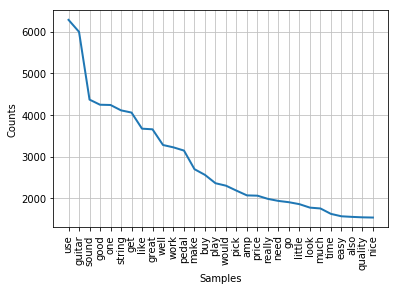

In [16]:
# Visualize the most common words in a histogram
tokens = nltk.tokenize.word_tokenize(" ".join(cleaned_X_train))
fd = nltk.FreqDist(tokens)
fd.plot(30,cumulative=False)

In this frequency plot we see that words like "good" appear a lot, which can also be seen in the distribution of the rating, as most frequent rating is 5.

## Transform Words to Vector

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=999, min_df = 0.001)

# Create a vector from the strings for train and test
train_vectors = vectorizer.fit_transform(cleaned_X_train)
test_vectors = vectorizer.transform(cleaned_X_test)

print(train_vectors.shape, test_vectors.shape)

(9234, 999) (1027, 999)


In [62]:
# Combine the features
train_complete = np.zeros((train_vectors.shape[0], train_vectors.shape[1]+1))
train_complete[:,-1] = sent_X_train
train_complete[:,:-1] = train_vectors.todense()

test_complete = np.zeros((test_vectors.shape[0], test_vectors.shape[1]+1))
test_complete[:,-1] = sent_X_test
test_complete[:,:-1] = test_vectors.todense()

print(train_complete.shape, test_complete.shape)

(9234, 1000) (1027, 1000)


## SMOTE
We use smote to balance the training set, such that the smaller classes are not overlooked. All the smaller classes are over sampled to have as many samples as the largest class.

In [63]:
# Due to the imbalanced set, we use SMOTE to resample the smaller classes in training
from imblearn.over_sampling import SMOTE
# Find the largest class in training
num_samples = int(np.max(bins_training[0]))
sm = SMOTE(random_state=42, ratio={1: num_samples, 2: num_samples, 3: num_samples, 4: num_samples, 5:num_samples})
# Fit and balance the training set
train_vectors_bal, y_train_bal = sm.fit_sample(train_complete, y_train)

## Evaluation Multinomial NB
As a benchmark we choose the multinomial naive Bayes classifier.

In [64]:
# Use a naive bayes approach as benchmark
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
# Fit the model
clf = MultinomialNB().fit(train_vectors_bal, y_train_bal)
# Predict on the test set
predicted = clf.predict(test_complete)
# Calculate accuracy for the balanced score
print("Multinomial NB Accuracy Score -> ",balanced_accuracy_score(y_test, predicted,y_fact))
conf_mat = confusion_matrix(y_test, predicted)
print(conf_mat)
print(conf_mat.diagonal(0)/np.sum(conf_mat, axis=-1))

Multinomial NB Accuracy Score ->  0.3675098114611076
[[  7   5   8   3   1]
 [  4   7   7   7   2]
 [  6   6  29  24   7]
 [ 10  17  49  63  62]
 [ 39  46  85 132 401]]
[0.29166667 0.25925926 0.40277778 0.31343284 0.57041252]


To evaluate the model, we choose a balanced accuracy metric. In comparison to the standard accuracy, this takes into account that smaller classes have a higher weighting than samples from the most common class.
Additionally, we show the confusion matrix that shows, where most of the misclassifications occured.

## Logistic Regression
Next, we use Logistic Regression to predict the classes.

In [66]:
from sklearn.linear_model import LogisticRegression
smote = LogisticRegression(solver='liblinear').fit(train_vectors_bal, y_train_bal)
smote_pred = smote.predict(test_complete)
print("Logistic Regression -> ", balanced_accuracy_score(y_test, smote_pred, y_fact))
conf_mat = confusion_matrix(y_test,smote_pred)
print(conf_mat)
print(conf_mat.diagonal(0)/np.sum(conf_mat, axis=-1))

/Users/David/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression ->  0.401539795883865
[[ 10   5   4   3   2]
 [  4   8   8   6   1]
 [  4   9  26  26   7]
 [ 13  15  40  65  68]
 [ 24  43  79 128 429]]
[0.41666667 0.2962963  0.36111111 0.32338308 0.61024182]


In comparison to the previous model, the accuracy on the boundary classes improves. It should be added, that most misclassifications of both model occur on neighbouring classes. This is due to the fact, that it is difficult to differentiate between a 5* and 4* review. 

## Next Steps

- Add categorical sentiments, instead of just looking at poisitve/negative.
- Analyze a utility for the words. Words like "guitar" or "string" won't help, as they are mentioned in both good and bad reviews and should be removed. This could be achieved by calculating correlations between the tokenized words and the classes.
- Another metric may suit this problem better, where this slight misclassification are not counted as severely.